In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as ss
import math
import seaborn as sns

In [2]:
doc_reports = pd.read_csv('doc_reports.csv', index_col=0).add_prefix('DOC_') #import doc report table
doc_reports['DOC_properties'] = [i.replace("\'", "\"") for i in doc_reports['DOC_properties']]
doc_reports['DOC_properties'] = [i.replace('None', "\"NaN\"") for i in doc_reports['DOC_properties']]
#expand json column
load = doc_reports['DOC_properties'].apply(json.loads).values.tolist()
dump = json.dumps(load)

doc_reports = doc_reports.join(pd.read_json(dump)).drop(columns=['DOC_properties'] , axis=1)

In [3]:
facial_similarity_reports = pd.read_csv('facial_similarity_reports.csv', index_col=0).add_prefix('FACE_') #import facial table

In [4]:
merged = (pd.merge(doc_reports, facial_similarity_reports, left_on = doc_reports.index ,right_on=facial_similarity_reports.index, how = 'right')) #merge the two tables
print(merged[merged.DOC_attempt_id != merged.FACE_attempt_id][['DOC_attempt_id','FACE_attempt_id']]) #columns is are identical, can drop one of them


       DOC_attempt_id                   FACE_attempt_id
168513     9.6949E+31  96948966045741509980950989095520


In [5]:
merged.drop(['FACE_user_id','FACE_visual_authenticity_result','key_0','FACE_attempt_id'],axis=1,inplace=True) #drop identical columns
merged = merged.set_index(['DOC_user_id']).sort_index()

In [6]:
merged.FACE_created_at = pd.to_datetime(merged.FACE_created_at) #dates to datetime format
merged.DOC_created_at = pd.to_datetime(merged.DOC_created_at)#dates to datetime format


In [7]:
#transform columns into binary format
merged['result'] = np.where(((merged['DOC_result'] == 'clear' ) & (merged['FACE_result'] == 'clear')), 1, 0)
merged['result_doc'] = np.where(((merged['DOC_result'] == 'clear' )), 1, 0)
merged['result_face'] = np.where(((merged['FACE_result'] == 'clear' )), 1, 0)
merged['DOC_image_integrity_result'] = np.where(((merged['DOC_image_integrity_result'] == 'clear' )), 1, 0)
merged['DOC_visual_authenticity_result'] = np.where(((merged['DOC_visual_authenticity_result'] == 'clear' )), 1, 0)
merged['DOC_face_detection_result'] = np.where(((merged['DOC_face_detection_result'] == 'clear' )), 1, 0)
merged['DOC_image_quality_result'] = np.where(((merged['DOC_image_quality_result'] == 'clear' )), 1, 0)
merged['DOC_colour_picture_result'] = np.where(((merged['DOC_colour_picture_result'] == 'clear' )), 1, 0)
merged['DOC_conclusive_document_quality_result'] = np.where(((merged['DOC_conclusive_document_quality_result'] == 'clear' )), 1, 0)



In [8]:
attempts_df = pd.DataFrame(merged.groupby('DOC_user_id')['DOC_result'].count()) #number of attempts

In [9]:
one_attempt = merged.loc[attempts_df[attempts_df['DOC_result'] == 1].index] #users with only one attempt

In [10]:
two_attempt = merged.loc[attempts_df[attempts_df['DOC_result'] == 2].index] #users with two attempts

In [11]:
other_att = merged.loc[attempts_df[attempts_df['DOC_result'] > 2].index] #users with more than 2 attemps

In [12]:
#computing pass rates for one attempt user
pass_rate_1att = len(one_attempt[one_attempt['result'] == 1])/len(one_attempt)
pass_rate_1att_overall = len(one_attempt[one_attempt['result'] == 1])/(len(one_attempt)+len(two_attempt)+len(other_att))
print(pass_rate_1att,pass_rate_1att_overall)

0.9434468262453114 0.5903040747375343


In [13]:
#create table to plot overall, document and face pass rates
pass_rate = merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result': 'sum'})/merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result': 'count'})
pass_rate['doc_rate'] = merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_doc': 'sum'})/merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_doc': 'count'})
pass_rate['face_rate'] = merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_face': 'sum'})/merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_face': 'count'})

In [14]:
pass_rate = pass_rate.rename(columns={'result':'overall'})

<Figure size 1440x720 with 0 Axes>

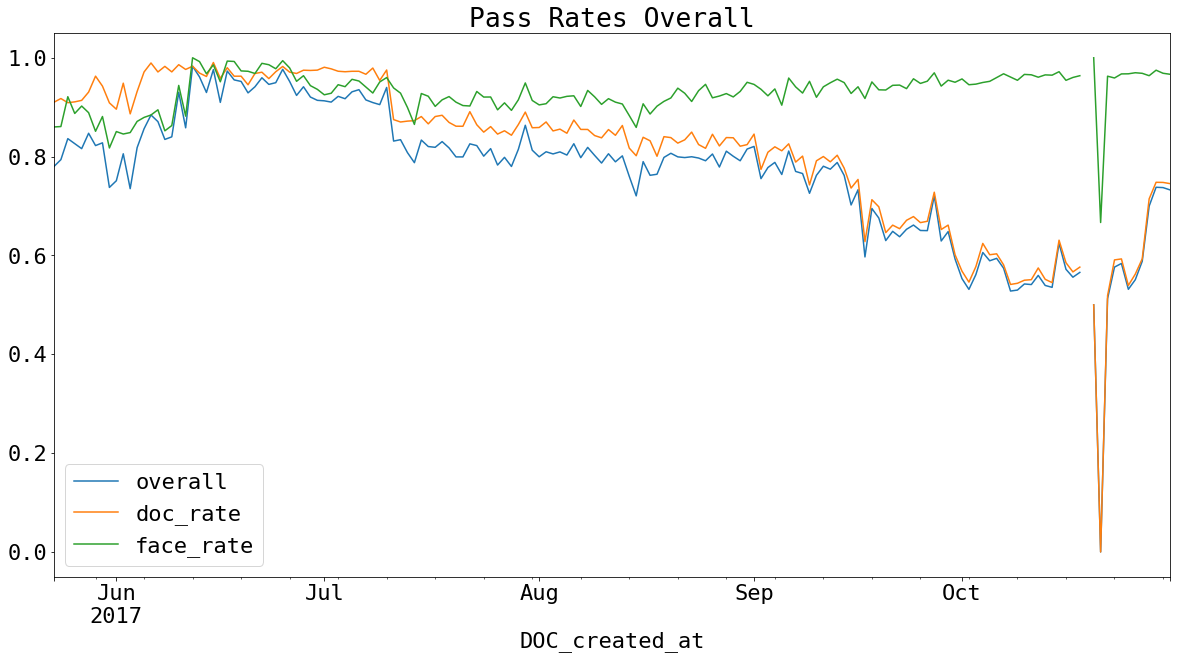

In [15]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.family'] = 'monospace'
plt.rcParams.update({'font.size': 22})
plt.figure()
pass_rate.plot()
plt.title('Pass Rates Overall')
plt.legend(loc='best')
plt.savefig('fig/PassRate_time_Overall.png')



<Figure size 1440x720 with 0 Axes>

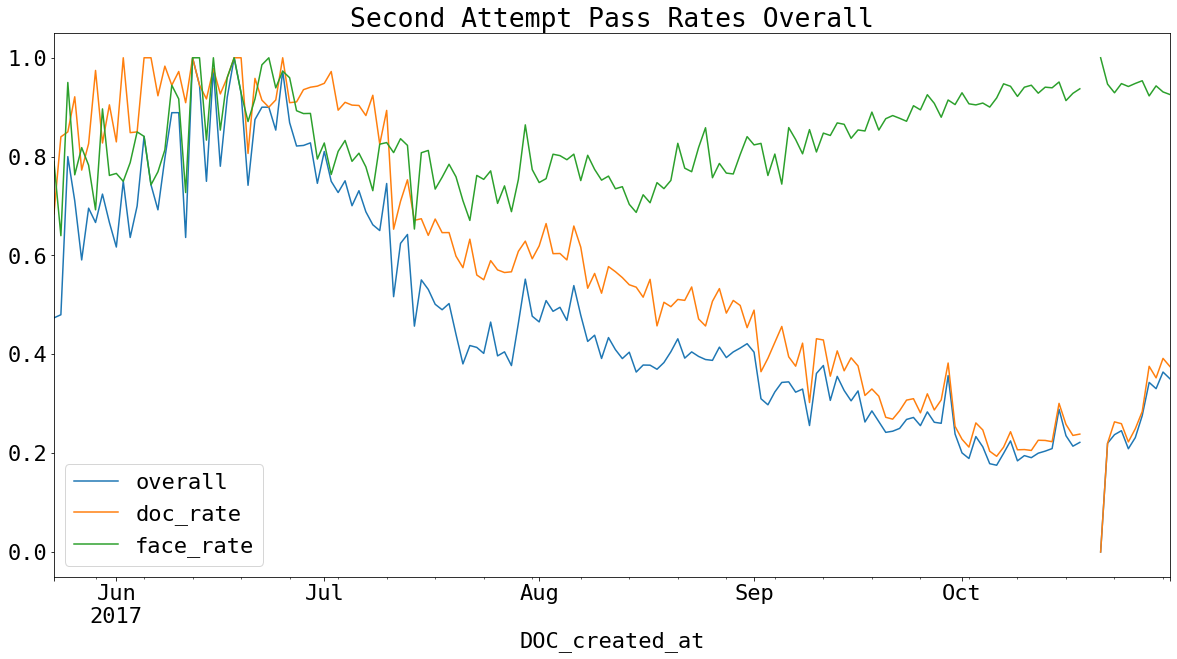

In [16]:
pass_rate2 = two_attempt.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result': 'sum'})/two_attempt.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result': 'count'})
pass_rate2['doc_rate'] = two_attempt.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_doc': 'sum'})/two_attempt.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_doc': 'count'})
pass_rate2['face_rate'] = two_attempt.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_face': 'sum'})/two_attempt.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_face': 'count'})
pass_rate2 = pass_rate2.rename(columns={'result':'overall'})
plt.figure()
pass_rate2.plot()
plt.title('Second Attempt Pass Rates Overall')
plt.legend(loc='best')
plt.savefig('fig/PassRate_time_Overall2.png')


In [17]:
#define plotting function
def plot(data,variable,attributes):
    df = [data[data[variable] == doc] for doc in attributes]
    a = data.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_doc': 'sum'})/data.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_doc': 'count'})
    for d,v in zip(df,(attributes)):
        a[v] = d.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_doc': 'sum'})/d.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_doc': 'count'})
    a = a.rolling(15).mean()
    return a

<Figure size 1440x720 with 0 Axes>

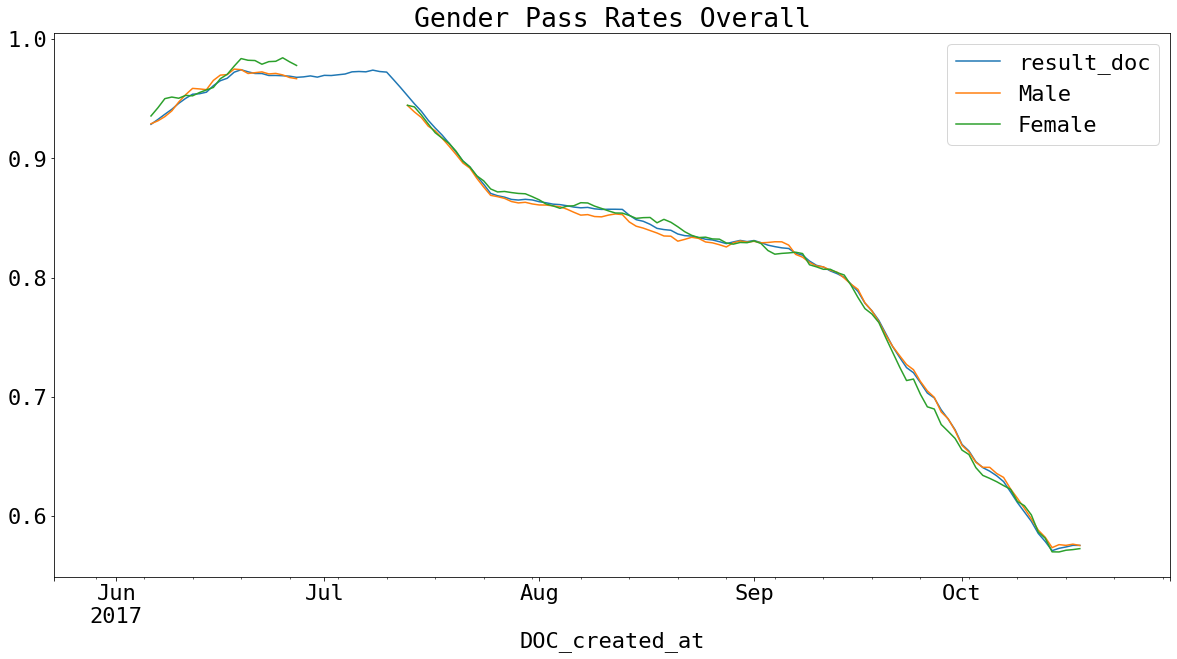

In [18]:
gender_pass_rate = plot(merged,'gender',['Male','Female'])
plt.figure()
gender_pass_rate.plot()
plt.title('Gender Pass Rates Overall')
plt.legend(loc='best')
plt.savefig('fig/gender_pass_rate.png')

<Figure size 1440x720 with 0 Axes>

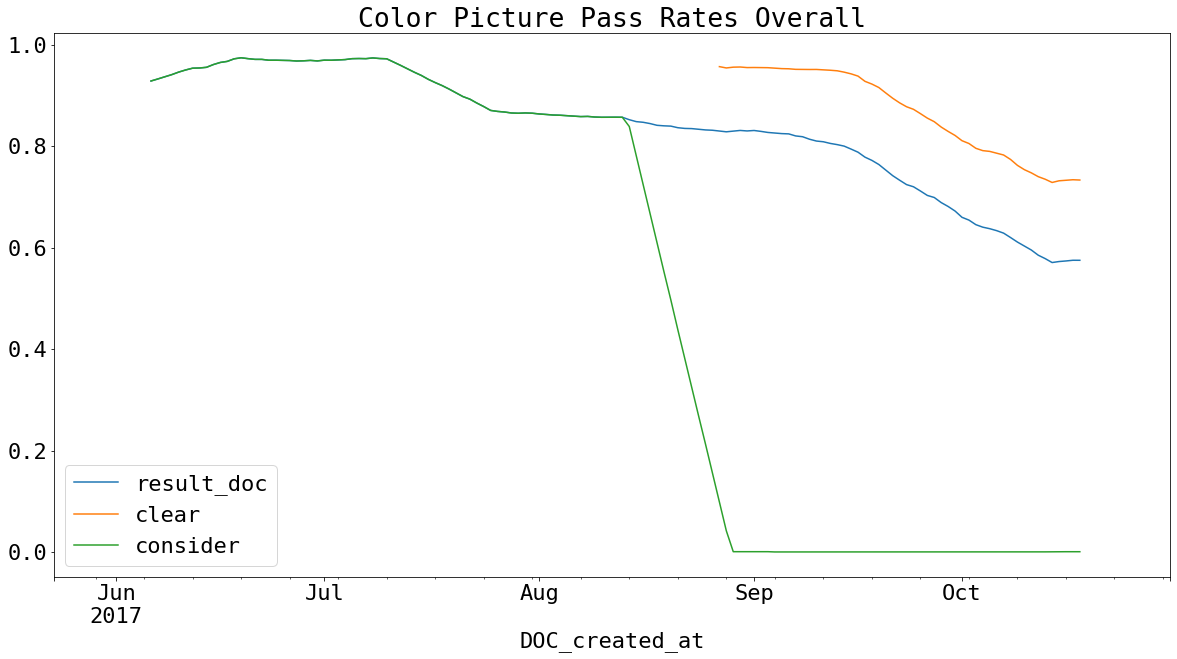

In [19]:
# plot(merged,'DOC_colour_picture_result',['consider','clear'])


DOC_colour_picture_result = plot(merged,'DOC_colour_picture_result',[1,0])
plt.figure()
DOC_colour_picture_result.plot()
plt.title('Color Picture Pass Rates Overall')
plt.legend(['result_doc','clear','consider'],loc='best')
plt.savefig('fig/col_pic.png')

<Figure size 1440x720 with 0 Axes>

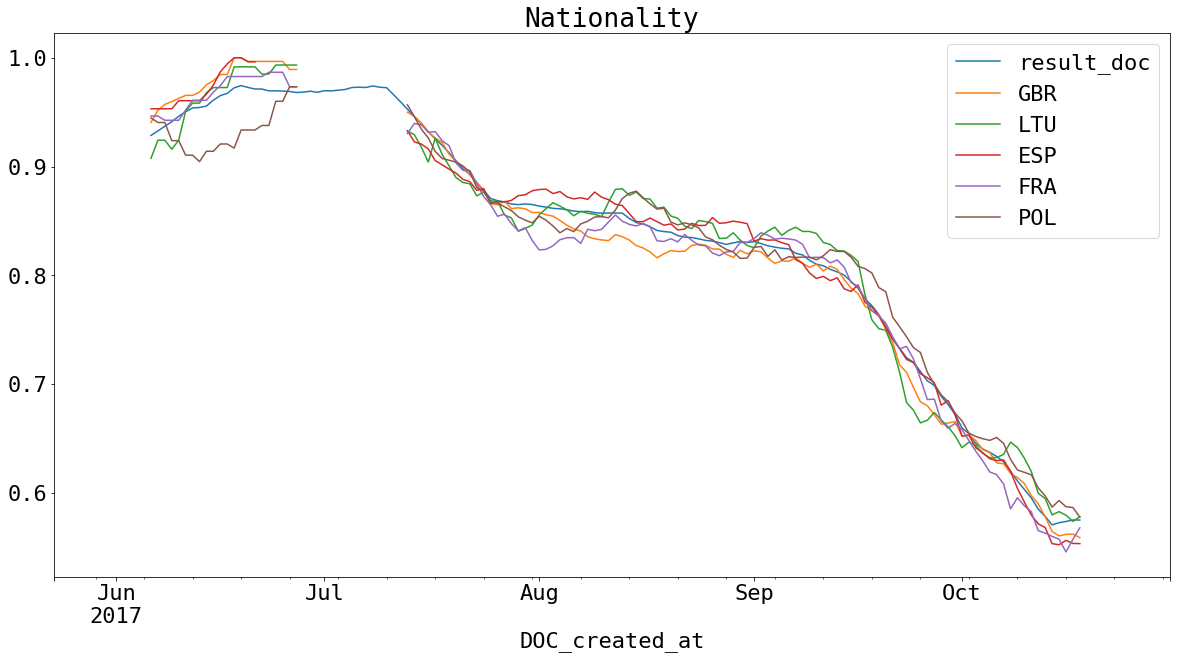

In [20]:

nationality = plot(merged,'nationality',two_attempt['nationality'].value_counts()[:5].index.tolist()
)
plt.figure()
nationality.plot()
plt.title('Nationality')
plt.legend(loc='best')
plt.savefig('fig/nationality.png')

<Figure size 1440x720 with 0 Axes>

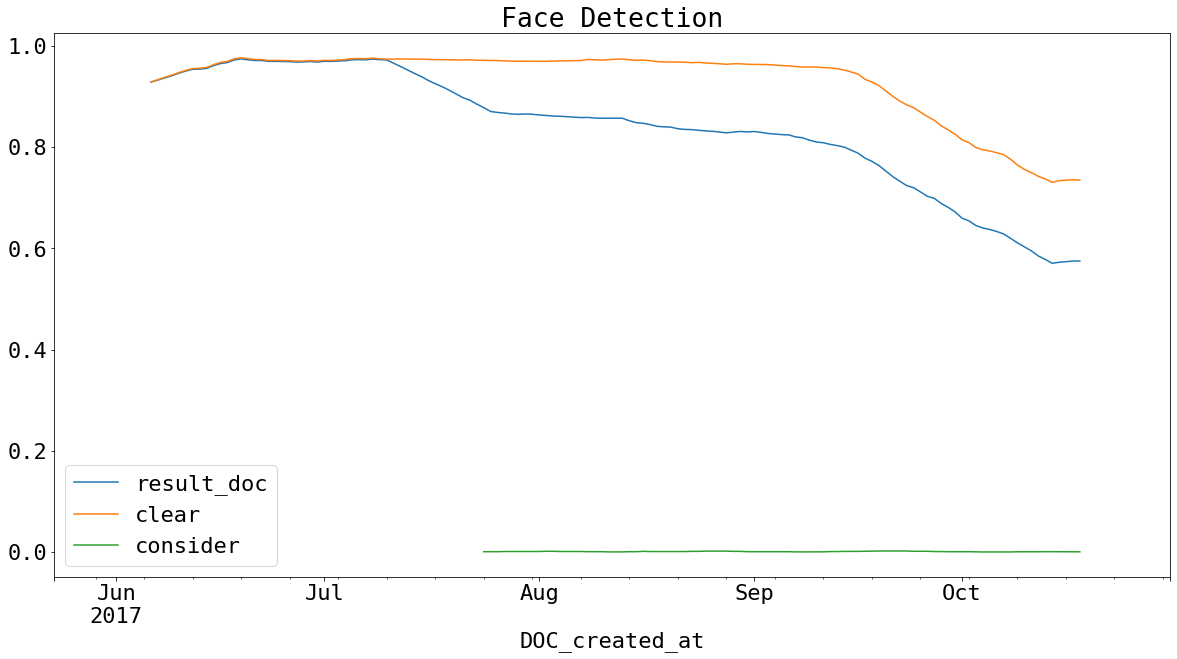

In [21]:
# plot(merged,'DOC_colour_picture_result',['consider','clear'])


face_detection = plot(merged,'DOC_face_detection_result',[1,0])
plt.figure()
face_detection.plot()
plt.title('Face Detection')
plt.legend(['result_doc','clear','consider'],loc='best')
plt.savefig('fig/face_detection.png')


<Figure size 1440x720 with 0 Axes>

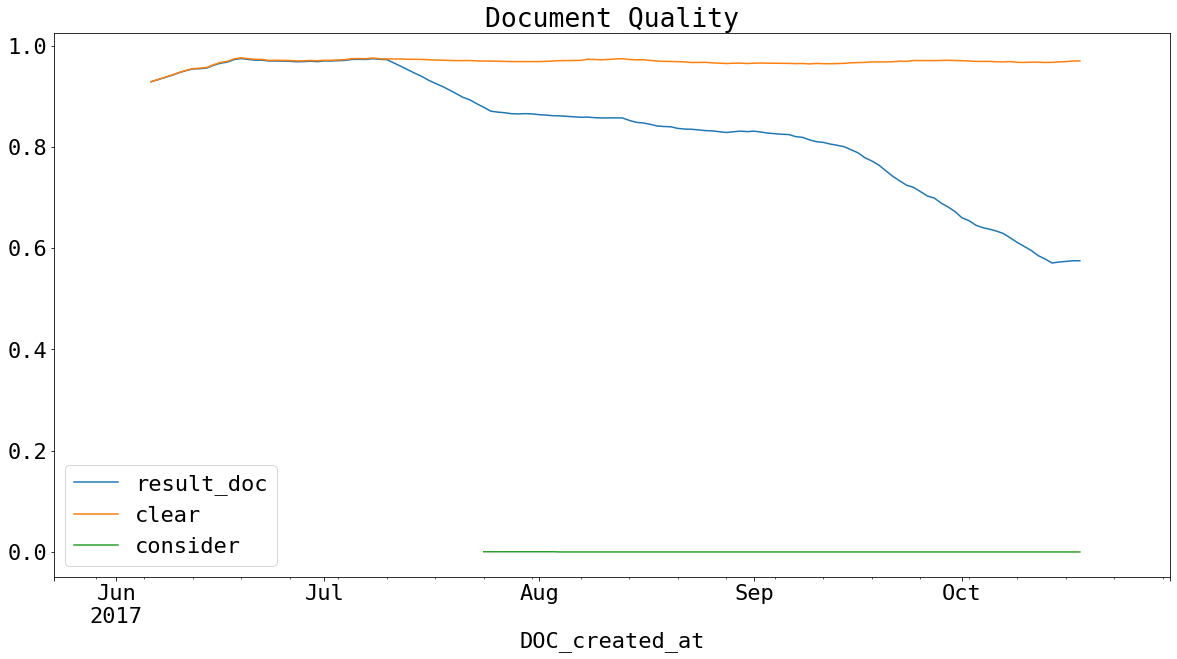

In [22]:

DOC_image_integrity_result = plot(merged,'DOC_image_integrity_result',[1,0])
plt.figure()
DOC_image_integrity_result.plot()
plt.title('Document Quality')
plt.legend(['result_doc','clear','consider'],loc='best')
plt.savefig('fig/document_quality.png')

In [23]:
merged.DOC_sub_result.unique()

array(['clear', 'rejected', 'caution', 'suspected'], dtype=object)

<Figure size 1440x720 with 0 Axes>

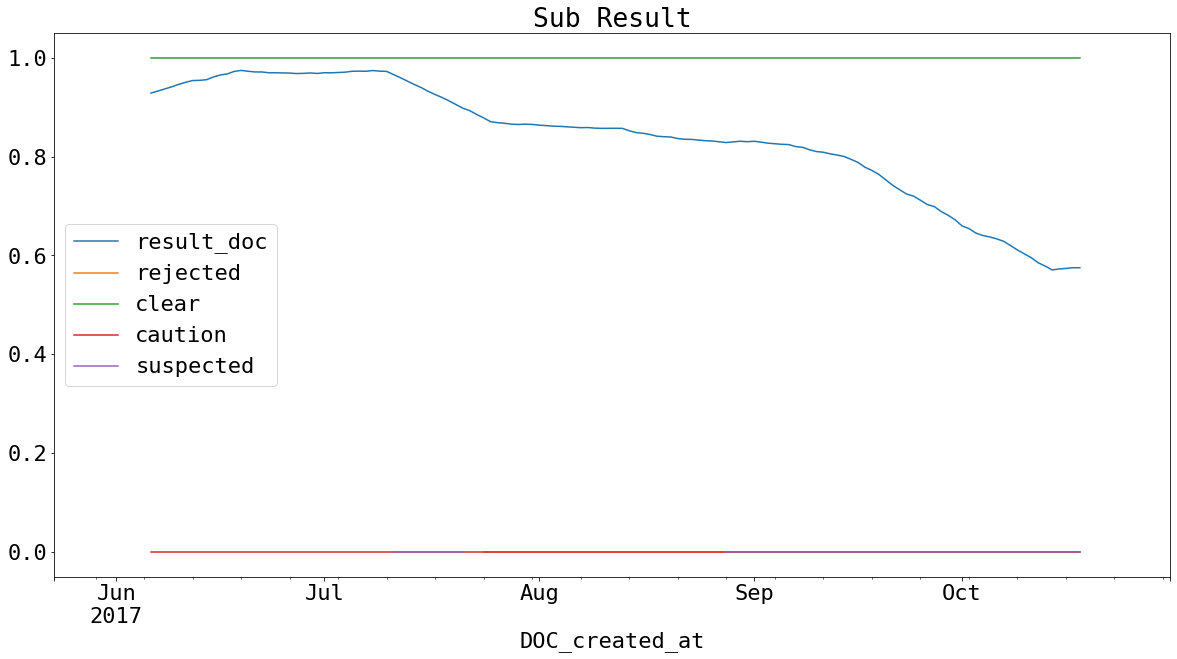

In [24]:
DOC_sub_result = plot(merged,'DOC_sub_result',['rejected', 'clear', 'caution', 'suspected'])
plt.figure()
DOC_sub_result.plot()
plt.title('Sub Result')
plt.legend(loc='best')
plt.savefig('fig/sub_result.png')
# DOC_sub_result.head(50)

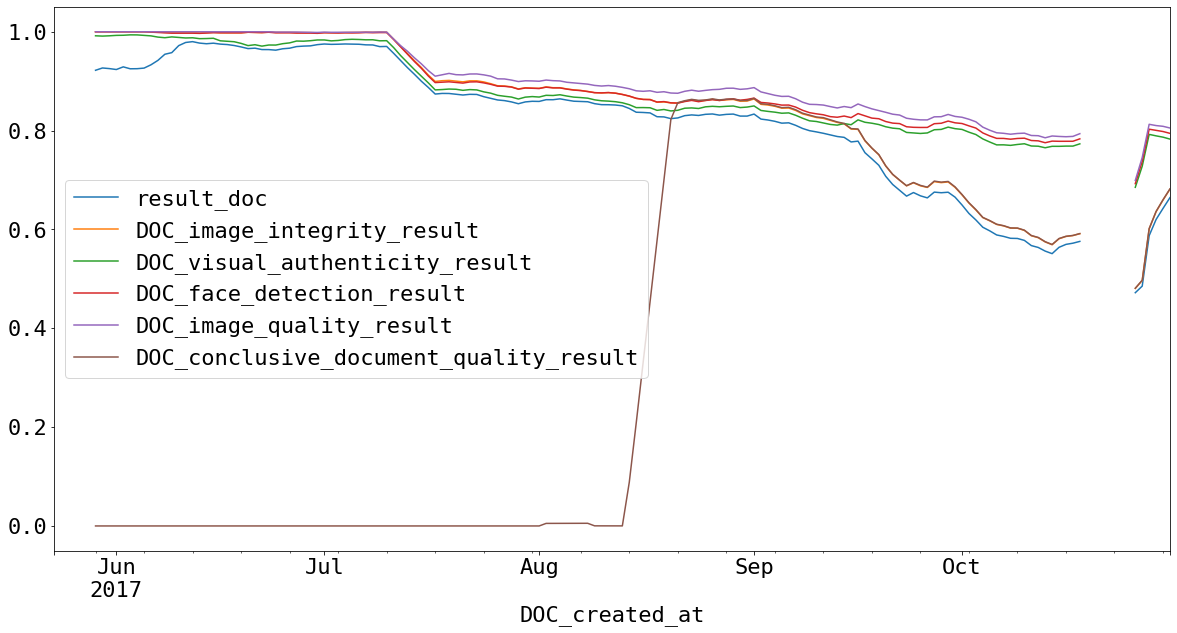

In [25]:
doc_pass_rate = merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_doc': 'sum'})/merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'result_doc': 'count'})
doc_pass_rate['DOC_image_integrity_result'] = merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_image_integrity_result': 'sum'})/merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_image_integrity_result': 'count'})
doc_pass_rate['DOC_visual_authenticity_result'] = merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_visual_authenticity_result': 'sum'})/merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_visual_authenticity_result': 'count'})
doc_pass_rate['DOC_face_detection_result'] = merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_face_detection_result': 'sum'})/merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_face_detection_result': 'count'})
doc_pass_rate['DOC_image_quality_result'] = merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_image_quality_result': 'sum'})/merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_image_quality_result': 'count'})
# doc_pass_rate['DOC_colour_picture_result'] = merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_colour_picture_result': 'sum'})/merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_colour_picture_result': 'count'})
doc_pass_rate['DOC_conclusive_document_quality_result'] = merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_conclusive_document_quality_result': 'sum'})/merged.groupby(pd.Grouper(key='DOC_created_at', freq='D')).agg({'DOC_conclusive_document_quality_result': 'count'})

doc_pass_rate = doc_pass_rate.rolling(7).mean()

doc_pass_rate.plot()

